# ADAcadabras Milestone 2

***Notebook containing main methods used to deal with the raw data, process it, and extract the main figures which will let us conduct our analysis.***

## General Information

As you will see, this notebook only loads and analyses the data from year 2020, considering it as the smallest dataset. Running the notebook as a TA for all years would constitute a large chunk of time, which is why the notebook will only address 2020.

***Libraries used:***
- python=3.8.12
- pandas
- datetime
- time
- matplotlib
- seaborn
- scipy
- pickle
- bz2
- json

***Files and directories to make this notebook run successfully:***

- **data/**
  - **parquet/**
    - *speaker_attributes.parquet*
    - *wikidata_labels_descriptions_quotebank.csv.bz2*
  - **filtered/**
    - **pickles/**
      - *quotes-2020-filtered.pkl.bz2*
    - *quotes-2020-filtered.json.bz2*
  - *quotes-2020.json.bz2*
- *data_processing.ipynb*
- *helper.py*



Directories are in **bold** and files are in *italic*


---

## Part 1

***Creating dataset D1 and analysing it(see README)***

We will extract the numbers we need from it all at once so we won't need to store it in memory since it represents the full Quotebank dataset from 2015 to 2020

In [14]:
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

import helper

In [2]:
PATH_DATA = './../data/'
PATH_PARQUET = PATH_DATA + 'parquet/'
PATH_DATA_OUT = PATH_DATA + 'counts/'
PATH_DATA_RESULT = './results/counts/' # ! in github repo, not local file

# After imports, go run those [cells](#all_weeks) for **results**

> should load result from the same path where we record them but voilà, minor adapt that will be done soon

Create an array containing all years of our study `[2015;2020]` and then create a loop on all the years. This notebook will only deal with the data from 2020 so that the TA's can run it in a reasonable amount of time during correction.

In [3]:
# Process one file at a time -> need to select a specific year
year = 2019 # available: from 2015 to 2020
QUOTES_FILE = PATH_DATA + f'quotes-{year}.json.bz2'

In [4]:
PARQUET_FILE = PATH_PARQUET + 'speaker_attributes.parquet'
WIKIDATA_LABELS_FILE = PATH_PARQUET + 'wikidata_labels_descriptions_quotebank.csv.bz2'


---

***Load Quotebank data into many chunks***

Loading into chunks makes the machine handle the large database in order to fit it into memory.

In [6]:
CHUNK_SIZE = 1e5

In [7]:
%%time

reader = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', chunksize=CHUNK_SIZE)

CPU times: user 885 µs, sys: 266 µs, total: 1.15 ms
Wall time: 741 µs


In [8]:
# Get a single chunk to show how the data's layout
for chunk in reader:
    df_0 = chunk
    break

# | quoteID | qotation | speaker | qids | date | numOccurrences | probas | urls | phase |
df_0.sample(5)

ValueError: Expected object or value

---

***Load Speaker's Metadata from the parquet file***

In [5]:
%%time

# | aliases | date_of_bitrh | nationality | gender | lastrevid | ethnic_group | US_congress_bio_ID | occupation | party | academic_degree | id | label | candidacy | type | religion |
df_parquet = pd.read_parquet(PARQUET_FILE)
df_parquet.head()

CPU times: user 18.6 s, sys: 3.46 s, total: 22 s
Wall time: 17.2 s


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


In [6]:
print(f'Parquet file shape: {df_parquet.shape}',
      f'Are ids unique?   : {df_parquet.id.nunique()==df_parquet.shape[0]}',
      f'{"-"*30}',
      'Count:',
      df_parquet.count(), sep='\n')

Parquet file shape: (9055981, 15)
Are ids unique?   : True
------------------------------
Count:
aliases               1203402
date_of_birth         5017333
nationality           3715852
gender                7105600
lastrevid             9055981
ethnic_group           130385
US_congress_bio_ID      12874
occupation            6373084
party                  399176
academic_degree         99995
id                    9055981
label                 8543681
candidacy               65442
type                  9055981
religion               196284
dtype: int64


**NOTE:** The counts above are differents because for a given QID, there might not exist every metadata possible (*e.g.* an author might not belong to a political party)

---

***Load the QID's of present instances in Quotebank*** 

It contains QID's of speakers, their gender, nationality and others if present. 

In [7]:
%%time

# | QID | Label | Description |
df_qid = pd.read_csv(WIKIDATA_LABELS_FILE, compression='bz2')

CPU times: user 207 ms, sys: 4.52 ms, total: 212 ms
Wall time: 211 ms


In [8]:
print(df_qid.describe().loc[['count', 'unique']])
df_qid.sample(4)

          QID  Label Description
count   36969  32951       24542
unique  36969  31462       17029


,QID,Label,Description
29692,Q3550123,Union of Communist Militants,NaN
22245,Q33112416,agrostologist,NaN
30066,Q5598970,Great Coalition,Canadian coalition of political parties
9001,Q95556323,dulcimerist,person who plays the dulcimer


We notice that QID's are unique as expected, but not labels and descriptions which can also be non-defined (*i.e.* NaN)

---

***Defining different useful dataframes for our analysis***

In [9]:
# Keep the metadata from parquet where a gender is defined (i.e. not None)
df_parquet_gender_noNa = df_parquet.dropna(subset=['gender'])

# Creating lists of unique QID's for genders
unique_gender_id, unique_speaker_index = helper.get_unique_list(df_parquet_gender_noNa.gender)
speakers_gender_qid = pd.DataFrame({'qids': unique_gender_id}) # sometimes, there are many genders for a speaker -> consider all of them

# Genders that are in parquet file and Quotebank
df_gender = df_qid[df_qid.QID.isin(speakers_gender_qid.qids)]

# Genders of speaker that are in Quotebank but NOT defined in the wikidata labels file
df_gender_ko = speakers_gender_qid[-speakers_gender_qid.qids.isin(df_gender.QID)]

<a id='error1'></a>
***Create a dataframe containing all unique genders present in Quotebank as indices, and the description of these genders according to the wikidata file, as well as the QID of the first speaker with the corresponding gender***

In [10]:
gender_names, gender_qids, speaker_qids, gender_description = [], [], [], []
count_not_rep = 0
for i in unique_speaker_index:
    for j in df_parquet_gender_noNa.gender.iloc[i]:
        speaker_qids.append(df_parquet_gender_noNa.id.iloc[i])
        gender_qids.append(j)
        gender_name = df_qid[df_qid.QID == j].Label.values
        if len(gender_name)>0:
            gender_names.append(gender_name[0])
            gender_description.append(df_qid[df_qid.QID == j].Description.values[0])
        else:
            count_not_rep += 1
            gender_names.append(f'--> Not repertiored [{count_not_rep}] ???')
            gender_description.append('-')

df_gender_firstSpeaker = pd.DataFrame({'gender_names':gender_names, 'gender_qids':gender_qids, 'speaker_qids':speaker_qids, 'description': gender_description})\
                        .groupby('gender_names').agg('first')
df_gender_firstSpeaker

,gender_qids,speaker_qids,description
gender_names,,,
--> Not repertiored [1] ???,Q15145782,Q78971059,-
--> Not repertiored [2] ???,Q15145783,Q2078379,-
Erkek,Q106299064,Q106375776,family name
Gorō,Q8964773,Q1515301,male given name
Taira no Kiyomori,Q281833,Q710537,Japanese samurai (1118-1181)
X-gender,Q96000630,Q2336456,a third gender or non-binary gender identity t...
agender,Q505371,Q4754807,absence of a gender identity
androgyny,Q207959,Q66283650,combination of male and female traits
assigned female at birth,Q99485785,Q492190,gender identity assigned at birth


In [45]:
# gender repertoriered > it exists in metadata
df_parquet[df_parquet.id == 'Q78971059']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3040274,"[Anne P. O'Brien, Anne O'Brien]",[+1954-00-00T00:00:00Z],[Q408],"[Q6581072, Q15145782]",1395620619,None,None,"[Q201788, Q1622272, Q482980]",None,None,Q78971059,Anne Philomena O'Brien,None,item,None


In [46]:
# but not labeled: empty output
df_qid[df_qid.QID == 'Q15145782']

,QID,Label,Description


Hand searching: [Q15145782](https://www.wikidata.org/wiki/Q15145782)'s label is also *transgender female*, which is a redirection to the labaled [Q1052281](https://www.wikidata.org/wiki/Q1052281) qid

<a id='error2'></a>
**NOTE:** We can notice some irregularities in the data: some QID's considered as genders are not really genders.
- **Queer, homosexuality:** Sexual orientation
- **Erkek, Gorō:** Family Names
- **Taira no Kiyomori:** Japanese Samurai
- **Male/female organism:** Not really an irregularity but since speakers are human, it should not exist as a gender in the database

There are also two QID's that correspond to transgender male/female when searching manually for them online, but they are not classified as such in the given wikidata file. A cause of this might be the fact that there already exists a QID for transgender males/females. Therefore, we will not drop them.

In [60]:
# Write result in CSV file
df_gender_firstSpeaker.description = df_gender_firstSpeaker.description.apply(lambda x: x.replace(',', '')) # avoiod separator char in text
df_gender_firstSpeaker.to_csv(PATH_DATA_OUT + 'genders.csv')

---

***This is the main code for analysing a given year of Quotebank***

We will count the number of quotations classified per gender and in time (per week)\
<a id='top'></a>
[bot](#bot)

In [81]:
# Reload the data to refresh the JsonReader (since it takes ~50µs to do so)
reader = pd.read_json(QUOTES_FILE, lines=True, compression='bz2', chunksize=CHUNK_SIZE)

#| YEAR | SIZE [GB] |   QUOTES    |  TIME [min] |
#|------|-----------|-------------|-------------|
#| 2015 |    3.3    |  20'874'338 |     22      |
#| 2016 |    2.3    |  13'862'129 |     20      |
#| 2017 |    5.2    |  26'611'588 |     47      |
#| 2018 |    4.8    |  27'228'451 |     46      |
#| 2019 |    3.6    |  21'763'302 |     36      |
#| 2020 |     .8    |   5'244'449 |      6      |
#|------|-----------|-------------|-------------|
#| SUM  |   20.0    | 115'584'257 |    177      |

count_male     = 0    # known speaker : men
count_female   = 0    # known speaker : women
count_others   = 0    # known speaker : other genders
count_wrong    = 0    # known speaker : specified gender is not a gender
count_noInfo   = 0    # known speaker : no info about gender
count_noMeta   = 0    # known speaker : no metadata about speaker
count_unknown  = 0    # unknown speaker
count_all      = 0    # all quotations

# list of Genders qid
wrong_genders = ['Erkek', 'Gorō', 'Taira no Kiyomori', 'queer', 'homosexuality']

qid_male    = [df_gender_firstSpeaker.loc['male'].gender_qids]
qid_female  = [df_gender_firstSpeaker.loc['female'].gender_qids]
qids_others = df_gender_firstSpeaker.drop(['male', 'female'] + wrong_genders)[['gender_qids']].gender_qids
qids_wrong  = df_gender_firstSpeaker.loc[wrong_genders].gender_qids

# Create dataframe to record weekly quotations per genders
col      = ['male', 'female', 'others','wrong', 'noInfo', 'noMeta', 'unknown', 'all']
index    = [i for i in range(1, 54)] # Represents 53 weeks (52 full + last incomplete, which is the 1st week of the following year)
df_count = pd.DataFrame(0, index=index, columns=col)

# DataFrame to record missing qids informations
speaker_male = pd.DataFrame()
speaker_female = pd.DataFrame()
speaker_others = pd.DataFrame()
speaker_wrong = pd.DataFrame()
speaker_noInfo = pd.DataFrame()
speaker_noMeta = pd.DataFrame()
speaker_unknown = pd.DataFrame()

begin = time()
chunk_begin = time()

# Note: prefix of variables m_ resp. q_ means that we manipulate metadata resp. quotations
for i, chunk in enumerate(reader):
    chunk['week']  = helper.get_week(chunk, 'quoteID')
    
    #_____
    # ALL
    #`````
    count_all += chunk.shape[0]
    df_count['all'] = df_count['all'].add(chunk.week.value_counts(), fill_value=0)

    #________________
    # SPEAKER UNKNOWN
    #````````````````
    # When there is an array of potential speakers, the 'speaker' column will contain the one with the highest probability. Sometimes, this speaker could be None.
    #   --> if 1st is [None]: not kept
    # 
    # When many QID's match a single name (homonyms): keep only the first QID 
    # (we assume that the true speaker and the selected homonym share the same gender)
    q_is_speaker_known      = chunk.qids.apply(lambda x: bool(x))
    q_speaker_known         = chunk[['week']][ q_is_speaker_known]
    q_speaker_unknown       = chunk[['week']][-q_is_speaker_known]
    q_speaker_known['qids'] = chunk[q_is_speaker_known].qids.apply(lambda x: x[0]) # 1st homonym
    q_speaker_unknown['qids'] = chunk[-q_is_speaker_known].qids # 1st homonym
    
    df_count.unknown = df_count.unknown.add(q_speaker_unknown.week.value_counts(), fill_value=0)
    count_unknown += chunk.shape[0]-q_speaker_known.shape[0]
    
    speaker_unknown = speaker_unknown.append(q_speaker_unknown.qids)
    
    #________________
    # SPEAKER NO META
    #````````````````
    m_is_speaker_known = df_parquet.id.isin(q_speaker_known.qids)
    m_speaker_known    = df_parquet[m_is_speaker_known][['gender', 'id']]
    
    q_is_speaker_meta       = q_speaker_known.qids.isin(m_speaker_known.id)
    q_speaker_known_no_meta = q_speaker_known[-q_is_speaker_meta]
    q_speaker_known_meta    = q_speaker_known[ q_is_speaker_meta]
    
    df_count.noMeta = df_count.noMeta.add(q_speaker_known_no_meta.week.value_counts(), fill_value=0)
    count_noMeta += q_speaker_known.shape[0]-q_speaker_known_meta.shape[0]
    
    # ID of known speakers without info
    speaker_noMeta = speaker_noMeta.append(q_speaker_known_no_meta[['qids']].drop_duplicates())
    
    #________________
    # GENDER NO INFO
    #````````````````
    m_is_gender_na = m_speaker_known.gender.isna()
    m_gender_known = m_speaker_known[-m_is_gender_na]
    q_is_gender_meta = q_speaker_known_meta.qids.isin(m_gender_known.id)
    q_gender_no_meta = q_speaker_known_meta[-q_is_gender_meta]
    q_gender_meta    = q_speaker_known_meta[ q_is_gender_meta]
    
    df_count.noInfo = df_count.noInfo.add(q_gender_no_meta.week.value_counts(), fill_value=0)
    count_noInfo += q_speaker_known_meta.shape[0]-q_gender_meta.shape[0]

    speaker_noInfo = speaker_noInfo.append(q_gender_no_meta[['qids']].drop_duplicates())
    
    #________________________
    # MALE - FEMALE - OTHERS
    #````````````````````````
    # Gender Count : if two gender: Only the 1st one count, not the others   
    m_is_male   = m_gender_known[m_gender_known.gender.apply(lambda x: x[0]).isin(qid_male)]
    m_is_female = m_gender_known[m_gender_known.gender.apply(lambda x: x[0]).isin(qid_female)]
    m_is_others = m_gender_known[m_gender_known.gender.apply(lambda x: x[0]).isin(qids_others)]
    m_is_wrong  = m_gender_known[m_gender_known.gender.apply(lambda x: x[0]).isin(qids_wrong)]
    
    q_gender_meta_male   = q_gender_meta[q_gender_meta.qids.isin(m_is_male.id)]
    q_gender_meta_female = q_gender_meta[q_gender_meta.qids.isin(m_is_female.id)]
    q_gender_meta_others = q_gender_meta[q_gender_meta.qids.isin(m_is_others.id)]
    q_gender_meta_wrong  = q_gender_meta[q_gender_meta.qids.isin(m_is_wrong.id)]    
    
    df_count.male   = df_count.male.add(q_gender_meta_male.week.value_counts(), fill_value=0)
    df_count.female = df_count.female.add(q_gender_meta_female.week.value_counts(), fill_value=0)
    df_count.others = df_count.others.add(q_gender_meta_others.week.value_counts(), fill_value=0)
    df_count.wrong  = df_count.wrong.add(q_gender_meta_wrong.week.value_counts(), fill_value=0)

    count_male   += q_gender_meta_male.shape[0]
    count_female += q_gender_meta_female.shape[0]
    count_others += q_gender_meta_others.shape[0]
    count_wrong  += q_gender_meta_wrong.shape[0]
    
    speaker_male   = speaker_male.append(q_gender_meta_male[['qids']].drop_duplicates())
    speaker_female = speaker_female.append(q_gender_meta_female[['qids']].drop_duplicates())
    speaker_others = speaker_others.append(q_gender_meta_others[['qids']].drop_duplicates())
    speaker_wrong  = speaker_wrong.append(q_gender_meta_wrong[['qids']].drop_duplicates())
    
    
    print(f'chunk {i+1} has been processed in {(time()-chunk_begin):.2f} [s]')
    chunk_begin = time() # Reset timer for next chunk
    
    k = 1
    if k == i:
        break
    
print(f'total time: {(time() - begin)//60} [min] and {(time()-begin)%60:.2f} [s]')

#_____________
# TOTAL COUNT
#`````````````
df_count.loc['sum'] = df_count.sum()
df_count = df_count.astype(int)

# might have same unknown in different chunk
speaker_male    = speaker_male.drop_duplicates()
speaker_female  = speaker_female.drop_duplicates()
speaker_others  = speaker_others.drop_duplicates()
speaker_wrong   = speaker_wrong.drop_duplicates()
speaker_noInfo  = speaker_noInfo.drop_duplicates()
speaker_noMeta  = speaker_noMeta.drop_duplicates()
#speaker_unknown = speaker_unknown.drop_duplicates()


chunk 1 has been processed in 12.08 [s]
chunk 2 has been processed in 15.53 [s]
total time: 0.0 [min] and 27.61 [s]


In [207]:
total = count_male+count_female+count_others + \
    count_wrong+count_noInfo+count_noMeta+count_unknown
print(f'known writer   | men                  | {count_male}',
      f'known writer   | women                | {count_female}',
      f'known writer   | other gender         | {count_others}',
      f'known writer   | wrong gender         | {count_wrong}',
      f'known writer   | no info about sex    | {count_noInfo}',
      f'known writer   | no meta about writer | {count_noMeta}',
      f'unknown writer |                        {count_unknown}',
      f'all            |                        {count_all}',
      f'''Checksum: {"OK" if total == count_all 
                            else f"Error while processing : sum= {total} != {count_all}"}''',
      sep='\n')

known writer   | men                  | 103892
known writer   | women                | 23833
known writer   | other gender         | 239
known writer   | wrong gender         | 0
known writer   | no info about sex    | 1477
known writer   | no meta about writer | 752
unknown writer |                        69807
all            |                        200000
Checksum: OK


In [209]:
df_count.sample(3)

,male,female,others,wrong,noInfo,noMeta,unknown,all
49,2077,480,2,0,29,13,1366,3967
6,2168,551,4,0,34,14,1552,4323
30,1464,317,3,0,18,9,940,2751


### results control

In [241]:
# index of the chosen person that will be described
chosen_one = 23

# gender is male
chosen_male = df_parquet[df_parquet.id.isin(speaker_male.iloc[chosen_one])]
male_desc = df_qid[df_qid.QID == chosen_male.gender.values[0][0]]
print(male_desc,'\n')
print(f'number of male speaker : {speaker_male.shape[0]}',
      f'their quotes           : {df_count.iloc[-1].male}',
      f'approx {(df_count.iloc[-1].male/speaker_male.shape[0]):.2f} quotes per person', sep='\n')
chosen_male

           QID Label                                        Description
2504  Q6581097  male  to be used in "sex or gender" (P21) to indicat... 

number of male speaker : 46131
their quotes           : 103892
approx 2.25 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3710882,None,None,None,[Q6581097],1376790398,None,None,None,None,None,Q16734497,Ted Phillips,None,item,None


In [242]:
# gender is female
chosen_female = df_parquet[df_parquet.id.isin(speaker_female.iloc[chosen_one])]
female_desc = df_qid[df_qid.QID == chosen_female.gender.values[0][0]]
print(female_desc,'\n')
print(f'number of female speaker : {speaker_female.shape[0]}',
      f'their quotes             : {df_count.iloc[-1].female}',
      f'approx {(df_count.iloc[-1].female/speaker_female.shape[0]):.2f} quotes per person', sep='\n')
chosen_female

           QID   Label                                        Description
7145  Q6581072  female  to be used in "sex or gender" (P21) to indicat... 

number of female speaker : 11889
their quotes             : 23833
approx 2.00 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3772621,None,[+1984-07-30T00:00:00Z],[Q717],[Q6581072],1372307274,None,None,"[Q33999, Q4610556]",None,None,Q21558740,Patricia Ramos,None,item,None


In [243]:
# gender is others
chosen_other = df_parquet[df_parquet.id.isin(speaker_others.iloc[chosen_one])]
other_desc = df_qid[df_qid.QID == chosen_other.gender.values[0][0]]
print(other_desc,'\n')
print(df_count.loc['sum'].others)
print(f'number of others speaker: {speaker_others.shape[0]}',
      f'their quotes            : {df_count.iloc[-1].others}',
      f'approx {(df_count.iloc[-1].others/speaker_others.shape[0]):.2f} quotes per person', sep='\n')
chosen_other

          QID       Label                                        Description
18845  Q48270  non-binary  range of gender identities that are not exclus... 

239
number of others speaker: 115
their quotes            : 239
approx 2.08 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
6248852,"[Dominique McLean, SonicFox5000]",[+1998-03-02T00:00:00Z],[Q30],[Q48270],1378527453,[Q49085],None,[Q4379701],None,None,Q59542692,SonicFox,None,item,None


In [244]:
# gender is none
chosen_none = df_parquet[df_parquet.id.isin(speaker_noInfo.iloc[chosen_one])]
print(f'number of None speaker: {speaker_noInfo.shape[0]}',
      f'their quotes          : {df_count.iloc[-1].noInfo}',
      f'approx {(df_count.iloc[-1].noInfo/speaker_noInfo.shape[0]):.2f} quotes per person', sep='\n')
chosen_none

number of None speaker: 1193
their quotes          : 1477
approx 1.24 quotes per person


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
562906,None,None,None,None,1194325643,None,None,[Q1650915],None,None,Q56808283,Courtney Price,None,item,None


In [269]:
# epmpty dataframe | do we catch them online ?
chosen_ko = df_parquet[df_parquet.id.isin(speaker_noMeta.iloc[chosen_one])]
print(f'number of speaker not repertoried: {speaker_noMeta.shape[0]}')
speaker_noMeta_labeled = df_qid[df_qid.QID == speaker_noMeta.iloc[chosen_one].qids]
chosen_ko

# are some of thespeaker that are not defined in parquet defined in label ? NO
# CODE

number of speaker not repertoried: 484


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion


In [246]:
# find a speaker according to gender in df_gender_firstSpeaker
# Certainly need to select other than the first gender -> adapt other_desc (2nd index)
chosen_gender_idx = 20 # MAX value : 38
chosen = df_parquet[df_parquet.id == df_gender_firstSpeaker.speaker_qids[chosen_gender_idx]]
other_desc = df_qid[df_qid.QID == chosen.gender.values[0][0]] # second index is 1 bc its second gender is not labeled
print('should be:', df_gender_firstSpeaker.index[chosen_gender_idx].upper())
print(other_desc,'\n')
chosen

should be: INTERSEX
           QID   Label                                        Description
7145  Q6581072  female  to be used in "sex or gender" (P21) to indicat... 



,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
2175,None,[+1986-07-06T00:00:00Z],[Q183],"[Q6581072, Q1097630]",1390189942,None,None,[Q10833314],None,None,Q72636,Sarah Gronert,None,item,None


**Note:** there are 0 wrong genders which might seem strange since we said that Quotebank contained those. But this also could be expected, because when considering only the first gender in the QID's array, the less important genders are dropped.

*Example:* Consider an imaginary quote from Samurai Jack, we would get as genders `['male', 'samurai']` but our code only takes into account `'male'`

---

***Results of previous 2 cells***

In [ ]:
# Write result in CSV file
df_count.to_csv(PATH_DATA_OUT + f'{year}_count.csv')
speaker_noMeta.to_csv(PATH_DATA_OUT + f'{year}_missing_meta.csv')

There aren't any quotes after week 16. This comes from the fact that the Quotebank dataset stopped analysing quotes until April 2020 (see [Quotebank paper](https://dlab.epfl.ch/people/west/pub/Vaucher-Spitz-Catasta-West_WSDM-21.pdf)). This is not the case for previous years as we have seen in our analysis, or as the TA's might see if they decide to run our notebook with the full years `[2015;2020]`

We also can output that the last month was april from the following code which would take ~5 mins to complete
```python
df_20 = pd.read_json(PATH_DATA+FILE_20, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
max_month = -1
for chunk in df_20:
    chunk['month'] = get_month(chunk, 'quoteID').astype(int)
    month = chunk.month.max()
    if month>max_month:
        max_month = month

print(f'max month in 2020 is: {max_month}')
```
> out: max month in 2020 is: 4

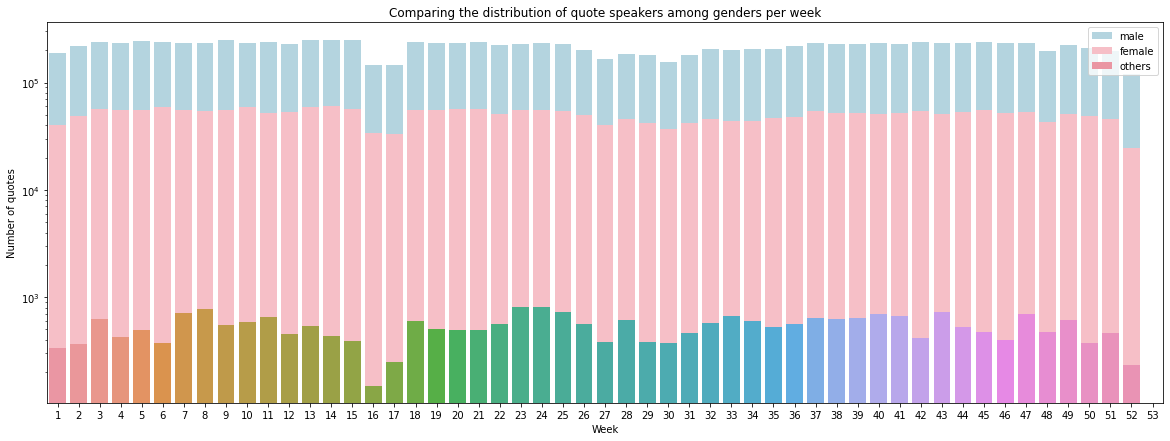

In [77]:
last_row = -1 # the last row is the sum -> plotted separately
if year == 2020:
    last_row = 16 # year 2020 ends in april (available data only first 16 week of the year)

sns.barplot(x=df_count.index[:last_row],y=df_count['male'].iloc[:last_row], color='lightblue', label='male')
sns.barplot(x=df_count.index[:last_row],y=df_count['female'].iloc[:last_row], color='lightpink', label='female')
sns.barplot(x=df_count.index[:last_row],y=df_count['others'].iloc[:last_row], label='others')
plt.yscale('log')

plt.xlabel('Week')
plt.ylabel('Number of quotes')
plt.title('Comparing the distribution of quote speakers among genders per week')
plt.legend()
plt.rcParams['figure.figsize'] = (20,7)
plt.show()

On this logarithmic-scale plot, we can clearly see the difference in the importance of each gender in media. The distribution of men and women speakers through time is roughly the same (see correlation below). However, for LGBT+ (other) speakers, they are rarer and seem to speak in peaks which might be correlated with events that happened that week.

In [24]:
print('Correlation : (Pearson correlation coefficient, p-value)')
print(f'Male/Female : {stats.pearsonr(df_count.iloc[:16]["male"], df_count.iloc[:16]["female"])}')
print(f'LGBT+/Total : {stats.pearsonr(df_count.iloc[:16]["others"], df_count.iloc[:16]["all"])}') # Lower correlation due to rarer data

Correlation : (Pearson correlation coefficient, p-value)
Male/Female : (0.9863442003930507, 2.2905848236518718e-12)
LGBT+/Total : (0.6518193884509832, 0.006220202646455371)


---

## Irregularities in data

### 1. Speaker not repertiored:
get speaker QID from \[speaker_noMeta\] and input it in \[df_parquet\] as follow:
``` python
i = 0
df_parquet[df_parquet.id == speaker_noMeta.iloc[i].values[0]]
```
> should return an empty DataFrame

Example:

i = 0 : [Q59209387](https://www.wikidata.org/wiki/Q59209387) does not exist\
i = 1 : [Q30337200](https://www.wikidata.org/wiki/Q30337200) Philippe Bouyer 

### 2. Gender not described:
*See first two rows of output of this [cell](#error1)*
If the link does not work, it is the output of python cell number 13.

### 3. Gender is not a real gender
*See explanation in this [cell](#error2)*
If the link does not work, it is the explanation under python cell number 13.

In [26]:
# Error to stop compilation of notebook:
EndError

NameError: name 'EndError' is not defined

<a id='all_weeks'></a>
# reload saved results

In [35]:
years = range(2015, 2021)
counts = [PATH_DATA_RESULT + f'{year}_count.csv' for year in years]
df_counts = []
for count in counts:
    df_counts.append(pd.read_csv(count, index_col='Unnamed: 0'))

df_all = pd.DataFrame()
week53 = pd.DataFrame()
for df, year in zip(df_counts, years):
    df = df.drop('sum')
    df.iloc[0:1] = df.iloc[0:1].add(week53, fill_value=0)
    week53 = df.iloc[-1:]
    df['year'] = year
    df['week'] = df.index.astype(int)
    df['idx'] = str(year) + ' - ' +df.index
    df_all = df_all.append(df.iloc[:-1]) # lost week 53 of last year (but as it ends at week 16: OK)
df_plot = df_all.copy().set_index('idx')
df_all = df_all.drop(columns='idx')
df_all = df_all.set_index(['year', 'week'])
df_all

male   female  others  wrong  noInfo  noMeta   unknown  \
year week                                                               
2015 1      67089.0   9736.0   123.0    0.0   576.0   319.0   39696.0   
     2     200940.0  32726.0   327.0    0.0  2296.0  1250.0  121896.0   
     3     220085.0  38426.0   430.0    0.0  2319.0  1572.0  135815.0   
     4     223480.0  40393.0   371.0    0.0  2409.0  1627.0  137456.0   
     5     229602.0  41393.0   476.0    0.0  2546.0  1491.0  140813.0   
...             ...      ...     ...    ...     ...     ...       ...   
2020 48         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     49         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     50         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     51         0.0      0.0     0.0    0.0     0.0     0.0       0.0   
     52         0.0      0.0     0.0    0.0     0.0     0.0       0.0   

                all  
year week            
2015 1     117539.0  
     2     359435.0  
     3     398647.0  
     4     405736.0  
     5     416321.0  
...             ...  
2020 48         0.0  
     49         0.0  
     50         0.0  
     51         0.0  
     52         0.0  

[312 rows x 8 columns]

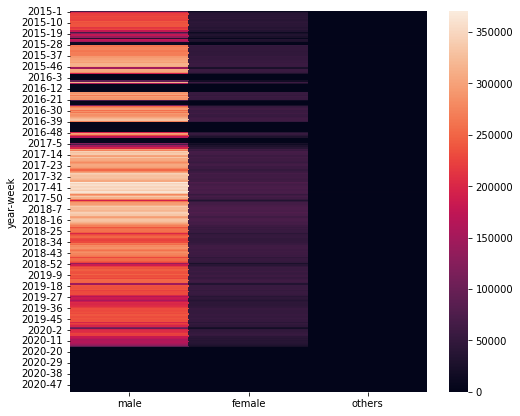

In [41]:
sns.heatmap(df_all[['male', 'female', 'others']])

### graph
> I don't know why but next cell need to be run **twice**

In [12]:
%%time


ax = sns.barplot(x=df_plot.index,y=df_plot.others+df_plot.female+df_plot.male, color='black', label='others')
ax = sns.barplot(x=df_plot.index,y=df_plot.male, color='lightblue', label='male')
ax = sns.barplot(x=df_plot.index,y=df_plot.female, color='lightpink', label='female')
ax = sns.barplot(x=df_plot.index,y=df_plot.others, label='others')
plt.yscale('log')

#ax.axvlines(x=df_plot.index[7]) # want to add vertival line btwn years

plt.xlabel('Week')
plt.ylabel('Number of quotes')
plt.title('Comparing the distribution of quote speakers among genders per week')
plt.legend()

In [13]:
plt.rcParams['figure.figsize'] = (8,7)
plt.show()

---

## Part 2

***Creating datasets D3 and D2 and storing them for later use (see README)***

In the README, we have mentioned in the **Methods** paragraph that there will be subsets to D2 and D3. In this notebook, we will only create D3. 
This is because D2 is in fact a subset of D3 (see `helper.py` for the definition of our keywords). The rest of the datasets will be derived from D3 for milestone 3.

In [101]:
import bz2
import json
import pickle as pkl
from time import time

import pandas as pd

from helper import keywords

In [4]:
# Uncomment in order to run for all years, here we just give the TA's 2020 for time purposes
years = reversed(range(2020, 2021))
# years = reversed(range(2015, 2021))

In [ ]:
for year in years:
    print(f'Started filtering year {year}:')

    path_to_file = f'data/quotes-{year}.json.bz2'
    path_to_out = f'data/filtered/quotes-{year}-filtered.json.bz2'
    path_to_pkl = f'data/filtered/pickles/quotes-{year}-filtered.pkl.bz2'

    begin = time()
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)  # loading a sample

                quote = str(instance['quotation']).lower()

                for word in keywords:
                    if word in f' {quote} ':
                        # writing in the new file
                        d_file.write(
                            (json.dumps(instance)+'\n').encode('utf-8'))
                        break
    end = time()
    print(f'   -Time elapsed to filter year {year}: {end-begin:.3f} seconds')

    begin = time()
    with bz2.open(path_to_pkl, 'wb') as f:
        data_reader = pd.read_json(
            path_to_out, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        for chunk in data_reader:
            pkl.dump(chunk, f)
    end = time()
    print(
        f'   -Time elapsed to write pickle for year {year}: {end-begin:.3f} seconds')

In [17]:
years = reversed(range(2020, 2021))

for year in years:
    print("oui")    
    
    path_to_pkl = f'./../data/Quotebank_processed/Quotebank/pickles/quotes-{year}-filtered.pkl'
    #f'data/filtered/pickles/quotes-{year}-filtered.pkl.bz2'
  
    begin = time()
    
    #with bz2.open(path_to_pkl, 'rb') as f:
    objects = []
    with (open(path_to_pkl, "rb")) as openfile:
        print(openfile)
        picklepkl.load(openfile, encoding='utf-8')
        print(data)
        '''

        print("oui")
        chunk = pickle.load(f)
        print(chunk.head())
        
        data_reader = pd.read_json(
            path_to_out, lines=True, compression='bz2', chunksize=CHUNK_SIZE)
        for chunk in data_reader:
            pkl.dump(chunk, f)
    '''
    end = time()
    print(f'   -Time elapsed to write pickle for year {year}: {end-begin:.3f} seconds')

[top](#top)
<a id='bot'></a>

In [20]:
# list of Genders qid
wrong_genders = ['Erkek', 'Gorō', 'Taira no Kiyomori', 'queer', 'homosexuality']

qid_male    = [df_gender_firstSpeaker.loc['male'].gender_qids]
qid_female  = [df_gender_firstSpeaker.loc['female'].gender_qids]
qids_others = df_gender_firstSpeaker.drop(['male', 'female'] + wrong_genders).gender_qids
qids_wrong  = df_gender_firstSpeaker.loc[wrong_genders].gender_qids

# Dataframe to record speaker quote and metadata
quote_column = ['quoteID','quotation','speaker','qids','date']
parquet_column = ['date_of_birth', 'gender', 'party', 'id']
q_male = pd.DataFrame()
q_female = pd.DataFrame()
q_others = pd.DataFrame()
q_wrong = pd.DataFrame()
q_noLabel = pd.DataFrame()
q_None = pd.DataFrame()

q_speaker_noLabel = pd.DataFrame()
q_speaker_noParquet = pd.DataFrame()
q_speaker_None = pd.DataFrame()

# label
df_qid
df_selected_parquet = df_parquet[speaker_meta_list]

In [142]:
years = range(2015, 2021+1)
year = years[1]
path_to_quotes = f'./../data/Quotebank_processed/Quotebank/quotes-{year}-filtered.json.bz2'
reader = pd.read_json(path_to_quotes, lines=True, compression='bz2', chunksize=1e3)

for i, chunk in enumerate(reader):
    chunk['week']   = helper.get_week(chunk, 'quoteID')
    chunk['month']  = helper.get_month(chunk, 'quoteID')
    chunk = chunk.filter(items=quote_column+['week', 'month'])
    
    # write a file for each month
    for month in chunk.month.unique():
        chunk_month = chunk[chunk.month==month]
        path_per_month = f'./../data/Quotebank_processed/Quotebank/quotes-{year}_{month}-filtered.json.bz2'
        #with bz2.open(path_per_month, 'a') as month_file:
        chunk_month.to_json(path_per_month, orient='columns')

    #_________________
    # SPEAKER NONE
    #`````````````````
    q_is_speaker_None = chunk.speaker=='None'
    q_noSpeaker       = chunk[ q_is_speaker_None]
    q_speaker         = chunk[-q_is_speaker_None].copy()
    q_speaker['qid'] = q_speaker.qids.apply(lambda x: x[0]) # 1st homonym
    q_speaker = q_speaker.drop(columns=['qids'])
    
    
    # Merge with Parquet
    q_speaker = q_speaker.merge(df_selected_parquet, left_on='qid', right_on='id', how='left')
    
    #______________
    # SPEAKER NO PARQUET
    #``````````````
    q_speaker_not_in_parquet = q_speaker.id.isna()
    q_speaker_noParquet  = q_speaker[q_speaker_not_in_parquet]
    
    q_speaker  = q_speaker[-q_speaker_not_in_parquet]
    
    '''
    #__________________
    # SPEAKER NO LABEL
    #``````````````````
    q_is_speaker_labeled = q_speaker.qid.isin(df_qid.QID)
    q_speaker_noLabel = q_speaker[ -q_is_speaker_labeled]
    q_speaker = q_speaker[ q_is_speaker_labeled]
    '''
    
    #______
    # NONE
    #``````
    q_gender_None = q_speaker.gender.isna()
    q_None    = q_speaker[ q_gender_None]
    q_speaker = q_speaker[-q_gender_None]
    
    q_speaker['gender'] = q_speaker.gender.apply(lambda x: x[0]) # keep only 1st gender
    
    #________________________________
    # MALE - FEMALE - OTHERS - WRONG - NOLABEL
    #````````````````````````````````
    q_is_gender_labeled = q_speaker.gender.isin(df_qid.QID)
    q_is_gender_male = q_speaker.gender.isin(qid_male)
    q_is_gender_female = q_speaker.gender.isin(qid_female)
    q_is_gender_others = q_speaker.gender.isin(qids_others)
    q_is_gender_wrong = q_speaker.gender.isin(qids_wrong)
    
    
    q_noLabel  = q_speaker[q_is_gender_labeled]
    q_male     = q_speaker[q_is_gender_male]
    q_female   = q_speaker[q_is_gender_female]
    q_others   = q_speaker[q_is_gender_others]
    q_wrong    = q_speaker[q_is_gender_wrong]
    
    print(f'chunk {i+1} processed')
    
    k = 1
    if k == i:
        break

chunk 1 processed
chunk 2 processed


In [1]:
# CREATE MONTHLY QUOTATION WHICH SPEAK ABOUT __WOMEN__

import bz2
import json
from time import time
years = range(2015, 2020+1)
start = time()
for year in years:
    path_to_quotes = f'./../data/Quotebank_processed/Quotebank/quotes-{year}-filtered.json.bz2' 
    begin = time()
    with bz2.open(path_to_quotes, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            month = instance['date'][5:7]
            path_per_month = f'./../data/Quotebank_processed/Quotebank/quotes-{year}-filtered/{year}_{month}.json.bz2'
            with bz2.open(path_per_month, 'ab') as d_file:
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
    print(f'year {year} have been procesed in {time()-begin} [s]')

print(f'full data have been processed in {time()-start} [s]')

year 2015 have been procesed in 509.97904872894287 [s]
year 2016 have been procesed in 411.3352587223053 [s]
year 2017 have been procesed in 840.6001105308533 [s]
year 2018 have been procesed in 892.9000463485718 [s]
year 2019 have been procesed in 669.9893839359283 [s]
year 2020 have been procesed in 138.45673274993896 [s]


FileNotFoundError: [Errno 2] No such file or directory: './../data/Quotebank_processed/Quotebank/quotes-2021-filtered.json.bz2'

In [12]:
import pandas as pd

year = 2017
month = 7
if month < 10:
    path_per_month = f'./../data/Quotebank_processed/Quotebank/quotes-{year}-filtered/{year}_0{month}.json.bz2'
else:
    path_per_month = f'./../data/Quotebank_processed/Quotebank/quotes-{year}-filtered/{year}_{month}.json.bz2'
    
df = pd.read_json(path_per_month, lines=True, compression='bz2')
df

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2017-07-19-071106,"Jimmy Bonanno, Sr. (Buildings & Grounds) misap...",Bob Cox,[Q4932153],2017-07-19 18:27:09,1,"[[Bob Cox, 0.9354], [None, 0.0617], [Little Ji...",[http://newrochelletalk.com/content/new-rochel...,E
1,2017-07-26-001796,"A few weeks ago, I competed in a race where I ...",None,[],2017-07-26 23:04:24,1,"[[None, 0.9222], [Kristof Allegaert, 0.0778]]",[http://www.thenational.scot/news/15436098.Edi...,E
2,2017-07-25-003493,"About seventh or eighth grade, his mom was lik...",Skip Wise,[Q7535742],2017-07-25 00:00:00,2,"[[Skip Wise, 0.6634], [None, 0.3098], [Carmelo...",[http://www.citypaper.com/news/all-content/bcp...,E
3,2017-07-13-005557,Alverson began cursing at Wilson because we di...,None,[],2017-07-13 19:30:00,4,"[[None, 0.9191], [Michael Wilson, 0.0809]]",[http://www.msn.com/en-us/news/crime/a-death-r...,E
4,2017-07-13-077246,Ms. Apfel epitomizes what we value in fashion ...,None,[],2017-07-13 04:00:00,1,"[[None, 0.8143], [Iris Apfel, 0.1857]]",[http://www.timesledger.com/stories/2017/28/ap...,E
...,...,...,...,...,...,...,...,...,...
160220,2017-07-07-058466,It was terrible and we laughed about it. Thing...,Michael Brown,"[Q10456471, Q11936682, Q1328702, Q15522038, Q1...",2017-07-07 13:00:00,3,"[[Michael Brown, 0.7379], [None, 0.2621]]",[http://havasunews.com/news/fire-victim-picks-...,E
160221,2017-07-14-062063,"It's getting old. She's showing her age,",Kirk Caldwell,[Q6415403],2017-07-14 07:18:51,1,"[[Kirk Caldwell, 0.8321], [None, 0.1679]]",[http://www.hawaiinewsnow.com/story/35883884/p...,E
160222,2017-07-21-072153,It's just such a feeling of relief and joy kno...,None,[],2017-07-21 18:00:00,1,"[[None, 0.5806], [Karen Hill, 0.4194]]",[http://americanpress.com/news/crime/murderer-...,E
160223,2017-07-13-070441,I've been preoccupied with franchises that are...,Zoe Saldana,[Q190162],2017-07-13 11:20:00,2,"[[Zoe Saldana, 0.9609], [None, 0.0391]]",[http://www.latimes.com/entertainment/la-ig-zo...,E


In [17]:
month = helper.get_month(df, 'quoteID')
month.unique()

array([7])

In [1]:
# CREATE MONTHLY QUOTATION WHICH SPEAK ABOUT __METOO__

import bz2
import json
from time import time


from helper import people_dict, metoo_dict, action_dict
keywords = people_dict\
          .union(metoo_dict)\
          .union(action_dict)

In [2]:
years = range(2015, 2020+1)
start = time()
for year in years:
    path_to_quotes = f'./../data/Quotebank_processed/Quotebank/quotes-{year}-filtered.json.bz2' 
    begin = time()
    with bz2.open(path_to_quotes, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            month = instance['date'][5:7]
            path_per_month = f'./../data/Quotebank_processed/Quotebank/metoo/metoo_quotes-{year}-filtered/metoo_{year}_{month}.json.bz2'
            
            quote = str(instance['quotation']).lower()
            with bz2.open(path_per_month, 'ab') as d_file:
                for word in keywords:
                    if word in f' {quote} ':
                        d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
                        break
    print(f'year {year} have been procesed in {time()-begin} [s]')

print(f'full data have been processed in {time()-start} [s]')

year 2015 have been procesed in 218.18607783317566 [s]
year 2016 have been procesed in 162.4482388496399 [s]
year 2017 have been procesed in 322.09760570526123 [s]
year 2018 have been procesed in 354.82442927360535 [s]
year 2019 have been procesed in 264.4676778316498 [s]
year 2020 have been procesed in 55.5454466342926 [s]
full data have been processed in 1377.5706887245178 [s]


In [5]:
import pandas as pd

year = 2020
month = 3
if month < 10:
    path_per_month = f'./../data/Quotebank_processed/Quotebank/metoo/metoo_quotes-{year}-filtered/metoo_{year}_0{month}.json.bz2'
else:
    path_per_month = f'./../data/Quotebank_processed/Quotebank/metoo/metoo_quotes-{year}-filtered/metoo_{year}_{month}.json.bz2'
    
df = pd.read_json(path_per_month, lines=True, compression='bz2')
df

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-03-10-007520,Beneath those those long cassocks -- whether b...,Carlo Poggioli,[Q5041579],2020-03-10 14:03:54,1,"[[Carlo Poggioli, 0.915], [Prince of Wales, 0....",[http://www.vulture.com/2020/03/the-new-pope-h...,E
1,2020-03-04-008310,But in practice giving a claim of `sex games g...,None,[],2020-03-04 11:02:44,1,"[[None, 0.8985], [Harriet Harman, 0.0631], [Ma...",[https://www.independent.co.uk/life-style/wome...,E
2,2020-03-03-010183,cultural movement centered on a set of social ...,Katherine Stewart,"[Q21466308, Q43390345, Q43392594, Q6376550]",2020-03-03 00:00:00,2,"[[Katherine Stewart, 0.6689], [None, 0.3312]]",[https://www.rawstory.com/2020/03/hot-topics-i...,E
3,2020-03-29-024263,The Diocese followed its established procedure...,None,[],2020-03-29 21:54:00,1,"[[None, 0.8938], [James Walsh, 0.1062]]",[https://www.timesleader.com/news/778191/pries...,E
4,2020-03-05-053457,Predators who actually travel in an attempt to...,None,[],2020-03-05 18:05:02,1,"[[None, 0.5368], [J. Douglas, 0.4632]]",[http://chattanoogan.com/2020/3/5/405198/Man-W...,E
...,...,...,...,...,...,...,...,...,...
5719,2020-03-05-055989,She has filed the rape case at least after 20 ...,None,[],2020-03-05 01:04:35,1,"[[None, 0.8382], [Narendra Mehta, 0.1618]]",[https://www.freepressjournal.in/mumbai/bombay...,E
5720,2020-03-07-019853,It's no surprise that Democrat logic in 2020 m...,None,[],2020-03-07 15:53:23,3,"[[None, 0.8521], [Steny Hoyer, 0.0417], [Laure...",[https://pjmedia.com/trending/majority-of-demo...,E
5721,2020-03-10-013870,Everyone speaks out says how sorry they are wh...,None,[],2020-03-10 15:00:21,3,"[[None, 0.9541], [Emily Sears, 0.0459]]",[http://greenwichtime.com/entertainment/articl...,E
5722,2020-03-09-039253,Men and women are much more likely to be satis...,Robin Milhausen,[Q7352658],2020-03-09 11:00:31,4,"[[Robin Milhausen, 0.8862], [None, 0.1138]]",[https://calgarysun.com/life/sex-files/0309-se...,E


**NOTE:** As already mentioned, this is only the output for the year 2020.

We have run the parsing code for every year in `[2015;2020]` and we got the following results:

Year | Original Size | Filtered Size | Pickle Size | Time to filter |
:---:|:-------------:|:-------------:|:-----------:|:--------------:|
2020 |792.3 MB       |59.7 MB        |55 MB        |6 min 47s       |
2019 |3.32 GB        |345.4 MB       |318.2 MB     |39 min 5s       |
2018 |4.48 GB        |462.6 MB       |425.8 MB     |52 min 14s      |
2017 |4.84 GB        |447.6 MB       |411.2 MB     |50 min 30s      |
2016 |2.16 GB        |210.1 MB       |193.1 MB     |23 min 42s      |
2015 |3.11 GB        |293 MB         |269.2 MB     |33 min 1s       |
Total|18.7 GB        |1.82 GB        |1.67 GB      |3h 25 min 19s   |

*N.B: file sizes correspond to the .bz2 compressed files and they depend on the compression algorithm in each OS*

We can see that dataset D3 is approximately 10 times smaller than the whole Quotebank, which focuses more towards answering our questions. We can also expect to miss a lot of quotes mentioning women, as well as take in D3 quote that do not mention women seeing that we are just taking the quotes mentioning them explicitely through our defined dictionary. But this is still enough for us to conduct our observations.

The creation of the pickle files is a way to load the data faster for later uses. The size of the data makes its handling take time in the order of hours which would be much more decreased when loading from pickle files, which reduces waiting time by a factor of ~9.

---

## What Next?

*What follow is a more detailed explanation of the __Methods__ paragraph in the __README__*.

* **Step 1: Data scraping, pre-processing and dataset construction.**\
  This is what has been run in the notebook

* **Step 2: General preliminary analysis using Quotebank entire dataset.**\
  In this step, we will plot the weekly percentage of quotes by author’s gender (men, women, other, unknown) from 2015 to 2020. This will allow us to have a general perspective on the place that women are being given in the mediatic place through time.
  With our result, we will see if the place given to woman, in terms of weekly percentage of speaker, correlates with the #MeToo movement important dates.

* **Step 3: Generate annual word clouds based on dataset D1.**
  From this, it would be interesting to use dataset D1 (containing all the quotes from women authors) to make a deeper analysis on the women’s quotes. By creating annual or 6-monthly word clouds, we would like to identify the main topics discussed by women in these quotes through time. ([Library possibly used](https://github.com/amueller/word_cloud))

* **Step 4: Investigate gender, political and generational biases in MeToo coverage using NLP to answer question A) with dataset D2.**\
  In this part, we will try to answer question A). For this, we will use dataset D2 and its subsets D2.1, D2.2 and D2.3, and we will train an NLP model (e.g. [spacy](https://spacy.io/usage/training)) with dataset AD3 to perform sentiment analysis on them. We will then perform a classification thanks to the trained NLP model on the whole dataset D2. By then subdividing D2 into D2.1, D2.2 and D2.3, we will perform the following analysis:
  1. **Investigate the gender biases:**\
    Plotting the percentages of men and women’s quotes in D2 and comparing them with the result obtained in step 1. We will see therefore if the way women are given voices differs talking about MeToo or in general.
    Thanks to the sentiment analysis previously performed, we will be able to identify any difference in tone between the gender by plotting distributions and visualizing the classes for quotes of each gender.
    We will generate word clouds for quotes of each gender to get a sense of the words most used when talking about MeToo depending on the gender.

  2. **Investigate political biases:**\
    Plotting the percentage of quotes in D2 for the different political parties.
    Thanks to the sentiment analysis previously performed, we will be able to identify any difference in tone between the political parties by plotting distributions and visualizing the classes for quotes of each party.
    We will generate word clouds for quotes of each political party to get a sense of the words most used when talking about MeToo depending on the gender.

  3. **Investigate generational biases:**\
    Plotting the percentage of quotes in D2 for the different age groups
    Thanks to the sentiment analysis previously performed, we will be able to identify any difference in tone between the age groups by plotting distributions and visualizing the classes for quotes of each group.
    We will generate word clouds for quotes of each age group to get a sense of the words most used when talking about MeToo depending on the age and gender.

  4. **Inherent biases in the structure of dataset D2:**\
    Various clustering trials with unsupervised different ML algorithms applied on the sentiment analysis classification probabilities returned previously. This aims at revealing clusters and therefore biases inherent to the data.

* **Step 5: Investigate general women perception via quotes mentioning women (dataset D3) in media to answer question B).**\
  This step aims to answer the question of the general perception of women in the media. We will investigate this problematic by using two different classifying NLP models applied to D3.
  Generate 6-monthly word clouds.
  Text Blob or Vader models for classifying the quotes as positive, negative or neutral. These NLP models return probabilities for the tone to be positive or negative. Probabilities thresholds will have to be set to determine the class boundaries.
  We will then train the SpaCy model on AD2 for classifying the quotes as misogynistic or non misogynistic. The trained model will then be used to classify the quotes of D3. Finally, we will plot the distributions of quote classes with respect to time.

* **Step 6: Correlate and investigate causation between MeToo general perception and women’s mediatic place to answer question C).**\
  This last step aims at answering if the evolution of women’s mediatization is correlated and has been tuned by the tendencies of MeToo’s mediatic perspective. To that end, we will make timelines, plot the data distributions and information previously collected, according to time, and compare them to major turning points and mediatization phases of the MeToo movement. We will investigate the statistical significance of the detected changes, variations of women’s mediatic place and mediatization before and after MeToo, thanks to adapted statistical tests.

* **Step 7: Github site building and Datastory redaction.**\
  MeToo movement timeline that will be useful for the Datastory and Data Analysis:
  In order to correlate our analysis with the key turning points and dates of the MeToo movement, we will use week bins, week timespans.
  This non-exhaustive list can be further completed thanks to the dates and key turning points of the MeToo movement, thanks to the data available on [this webpage.](https://www.refinery29.com/en-us/2018/10/212801/me-too-movement-history-timeline-year-weinstein)
